# Main imports and code - Preparation

In [1]:
# check which gpu we're using
!nvidia-smi

Mon Mar  4 02:20:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     Off | 00000000:01:00.0 Off |                   On |
| N/A   34C    P0              29W / 165W |     50MiB / 24576MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

+------------------+--------------------------------+-----------+-----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+


In [2]:
!pip install simpletransformers
!pip install tensorboardx
!pip install googletrans
!pip install nltk

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 3.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15733 sha256=dff125ca9014ebf03c0cbc795164759712bc962efd1572818a5b42dae2c29d50
  Stored in directory: /homes/vm23/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling id

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

2024-03-04 02:25:19.310682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 02:25:19.310736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 02:25:19.311634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 02:25:19.318155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 02:25:23.401389: W tensorflow/compiler/tf2

In [4]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [5]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2024-03-04 02:25:36.614282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 02:25:36.618500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-04 02:25:36.620941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Fetch Don't Patronize Me! data manager module

In [6]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [7]:
#the raw dataset
!wget -O dontpatronizeme_pcl.tsv https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv

--2024-03-04 02:25:58--  https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3122842 (3.0M) [text/plain]
Saving to: ‘dontpatronizeme_pcl.tsv’

dontpatronizeme_pcl 100%[===================>]   2.98M  --.-KB/s    in 0.01s   

2024-03-04 02:25:58 (234 MB/s) - ‘dontpatronizeme_pcl.tsv’ saved [3122842/3122842]



In [8]:
# their training selection set - i assume it's for picking up corresponding id from the raw dataset
!wget -O train_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

--2024-03-04 02:26:00--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241839 (236K) [text/plain]
Saving to: ‘train_semeval_parids-labels.csv’

train_semeval_parid 100%[===================>] 236.17K  --.-KB/s    in 0.005s  

2024-03-04 02:26:00 (44.0 MB/s) - ‘train_semeval_parids-labels.csv’ saved [241839/241839]



In [9]:
#their testing selection set
!wget -O dev_semeval_parids-labels.csv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv

--2024-03-04 02:26:01--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 61151 (60K) [text/plain]
Saving to: ‘dev_semeval_parids-labels.csv’

dev_semeval_parids- 100%[===================>]  59.72K  --.-KB/s    in 0.002s  

2024-03-04 02:26:01 (30.4 MB/s) - ‘dev_semeval_parids-labels.csv’ saved [61151/61151]



In [10]:
#testing set
!wget -O task4_test.tsv https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

--2024-03-04 02:26:03--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘task4_test.tsv’

task4_test.tsv      100%[===================>]   1.09M  --.-KB/s    in 0.009s  

2024-03-04 02:26:03 (127 MB/s) - ‘task4_test.tsv’ saved [1145277/1145277]



In [11]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [12]:
from dont_patronize_me import DontPatronizeMe

In [13]:
dpm = DontPatronizeMe('.', 'task4_test.tsv')

In [14]:
dpm.load_task1()
#Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
#Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.

## Load paragraph IDs

In [15]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [16]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [17]:
data=dpm.train_task1_df

In [18]:
data


,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [19]:
data = data.dropna()

# RAW Dataset - Q1.a Data Analysis Code

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


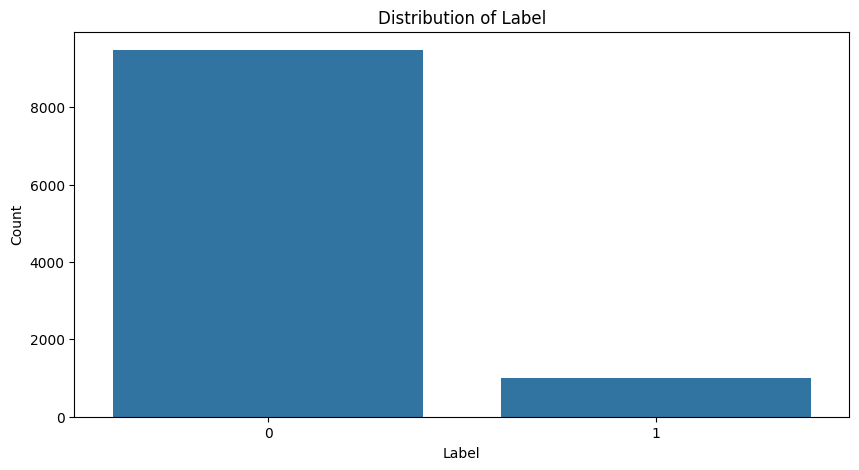

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


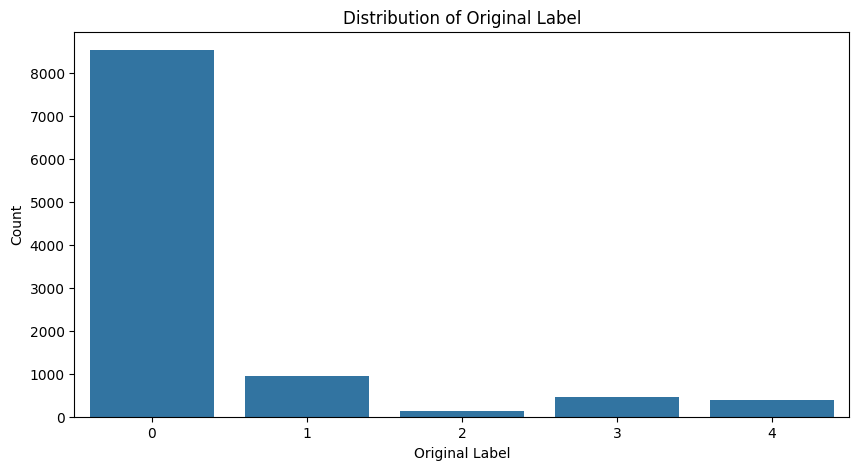

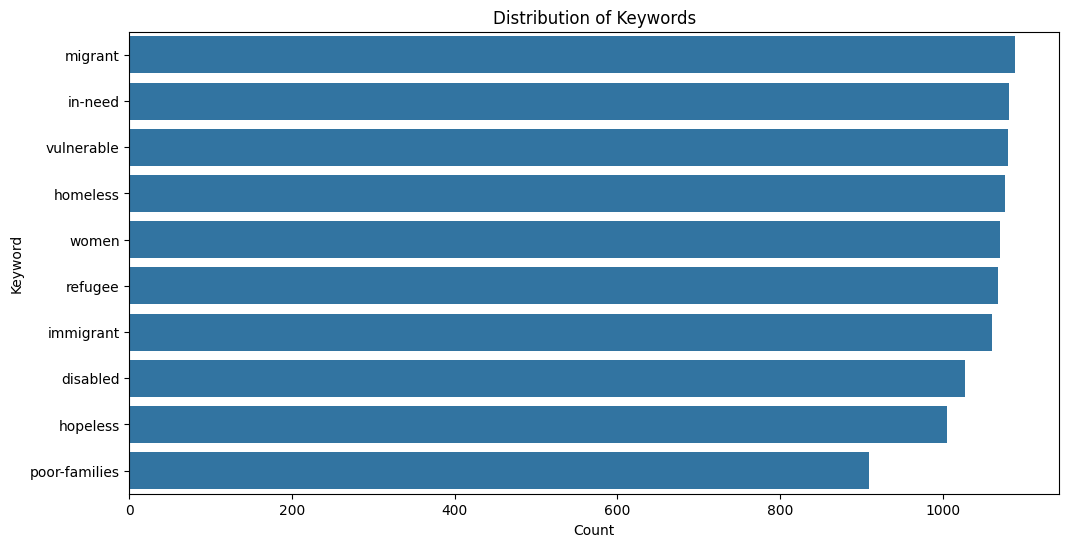

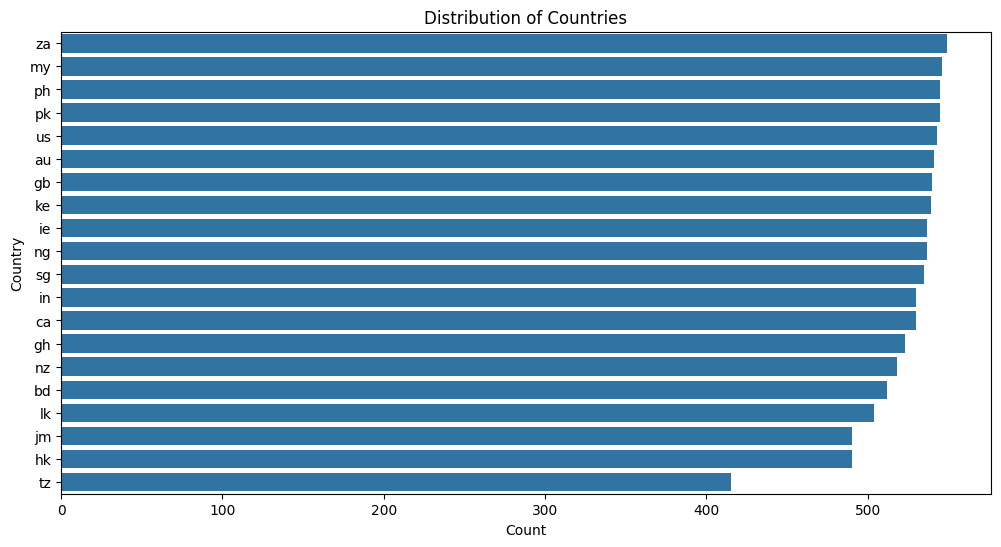

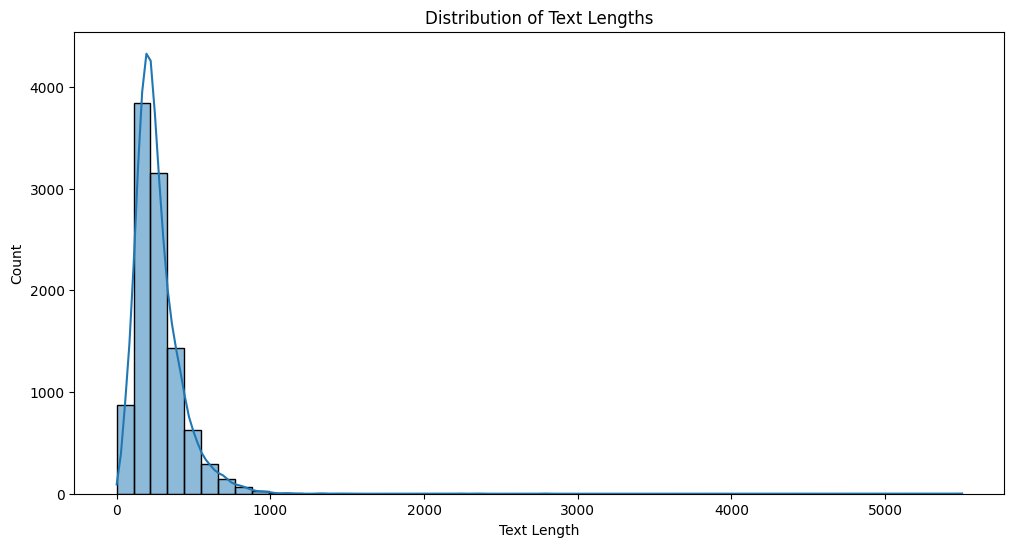

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_distribution = data['label'].value_counts()
orig_label_distribution = data['orig_label'].value_counts()

# distribution of 'label'
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=data)
plt.title('Distribution of Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# distribution of 'orig_label'
plt.figure(figsize=(10, 5))
sns.countplot(x='orig_label', data=data)
plt.title('Distribution of Original Label')
plt.xlabel('Original Label')
plt.ylabel('Count')
plt.show()


data['text_length'] = data['text'].apply(len)

# distribution of keywords
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='keyword', order = data['keyword'].value_counts().index)
plt.title('Distribution of Keywords')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

# distribution of countries
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='country', order = data['country'].value_counts().index)
plt.title('Distribution of Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

# distribution of text lengths
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='text_length', bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mean_length = data['text_length'].mean()
std_dev_length = data['text_length'].std()

threshold = mean_length + std_dev_length

data['text_length_category'] = data['text_length'].apply(lambda x: 'long' if x > threshold else 'short')
#.map({'long': 1, 'short': 0})


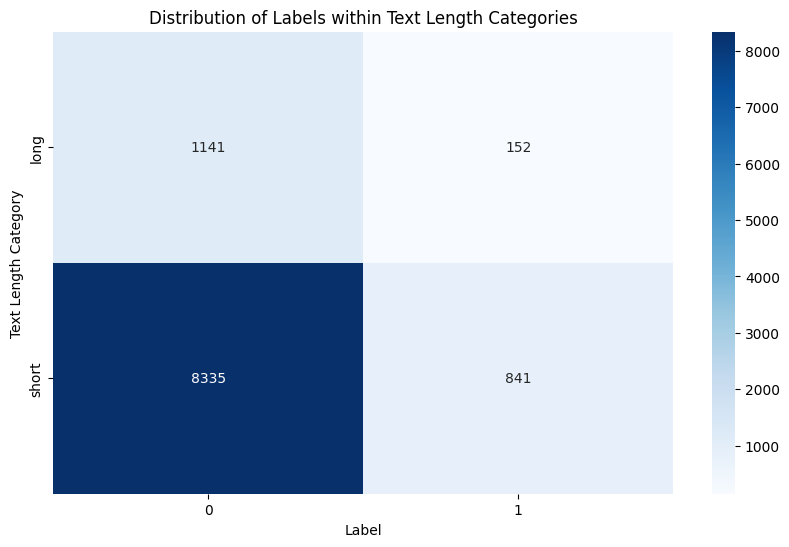

In [22]:

contingency_table = pd.crosstab(data['text_length_category'], data['label'])

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='g')
plt.title('Distribution of Labels within Text Length Categories')
plt.xlabel('Label')
plt.ylabel('Text Length Category')
plt.show()



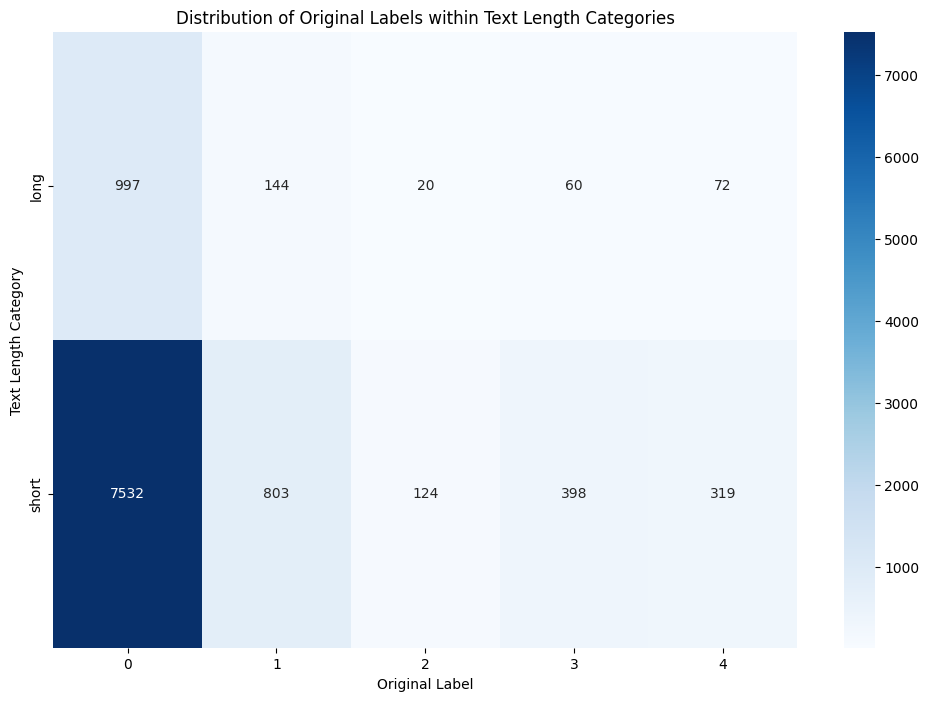

In [23]:
contingency_table_orig_label = pd.crosstab(data['text_length_category'], data['orig_label'])


plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_orig_label, annot=True, cmap='Blues', fmt='g')
plt.title('Distribution of Original Labels within Text Length Categories')
plt.xlabel('Original Label')
plt.ylabel('Text Length Category')
plt.show()


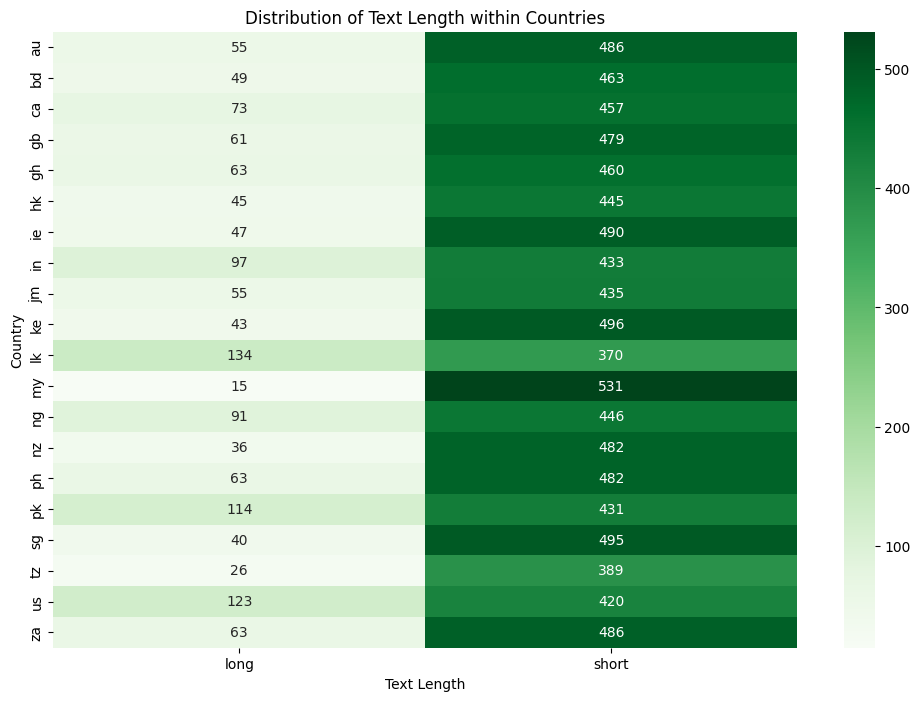

In [24]:

contingency_table_country = pd.crosstab(data['country'], data['text_length_category'])

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_country, annot=True, cmap='Greens', fmt='g')
plt.title('Distribution of Text Length within Countries')
plt.xlabel('Text Length')
plt.ylabel('Country')
plt.show()


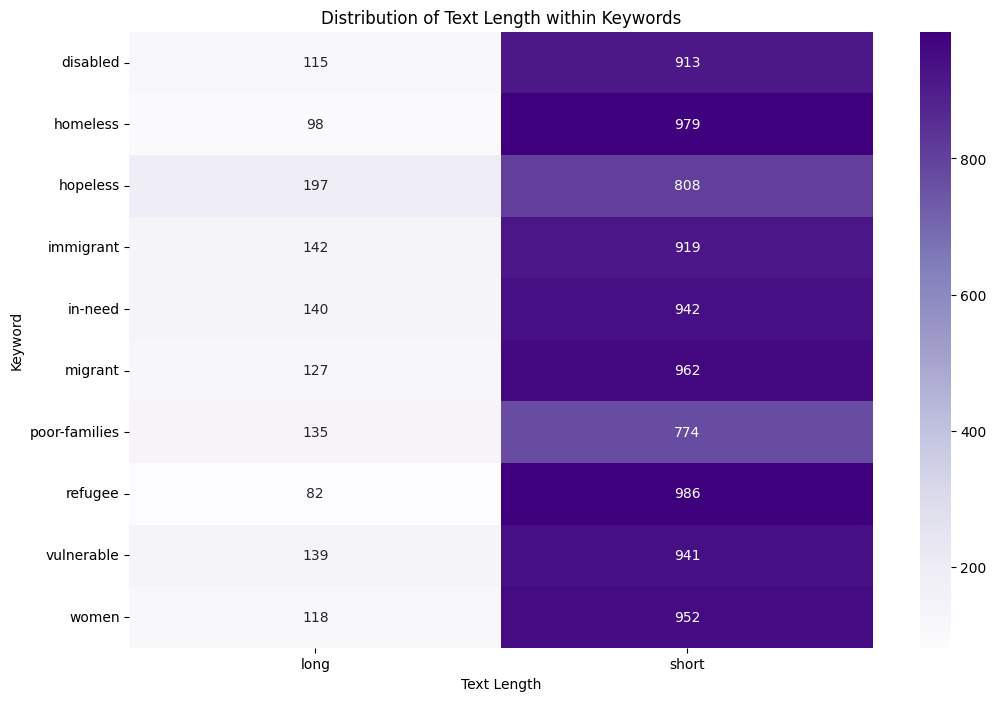

In [25]:

contingency_table_keyword = pd.crosstab(data['keyword'],data['text_length_category'])

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table_keyword, annot=True, cmap='Purples', fmt='g')
plt.title('Distribution of Text Length within Keywords')
plt.xlabel('Text Length')
plt.ylabel('Keyword')
plt.show()




## Get the raw training set (Task 1) - without split

In [26]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [27]:
import random

In [28]:
trdf1 = pd.DataFrame(rows)

In [29]:
trdf1

,par_id,community,text,label
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,The next immediate problem that cropped up was...,1
3,8279,vulnerable,Far more important than the implications for t...,1
4,1164,poor-families,To strengthen child-sensitive social protectio...,1
...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,You have to see it from my perspective . I may...,0


In [30]:
trdf1.to_csv("trdf1.csv")

## get the raw test set (Task 1)

In [31]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label
  })


In [32]:
len(rows)

2094

In [33]:
tedf1 = pd.DataFrame(rows)
#print(tedf1)

In [34]:
random.shuffle(tedf1.text.tolist())
tedf1.to_csv("tedf1.csv")
#shuffled_tedf1 = tedf1.sample(frac=1).reset_index(drop=True)

In [55]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix


def evaluate_model(true_labels, preds):
    f1 = f1_score(true_labels, preds)
    accuracy = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    conf_matrix = confusion_matrix(true_labels, preds)
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


    print("Confusion Matrix:")
    print(conf_matrix)

def compute_metrics(p):
    predictions = p.predictions.argmax(axis=1)
    labels = p.label_ids

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='binary')


    # return {"accuracy": accuracy, "f1": f1, "predictions": list(predictions)}
    return {"accuracy": accuracy, "f1": f1}



## RoBERTa Baseline with Downsampled raw data for Task 1

In [36]:
print(len(trdf1[trdf1.label==0]))
print(len(trdf1[trdf1.label==1]))
print((len(trdf1[trdf1.label==0]))/len(trdf1[trdf1.label==1]))

7581
794
9.547858942065492


Neg is 10 times more than positive class.

### RoBERTa Negative : Positive = 2:1

- non-pcl : pcl = 2:1
- 46.7% F1 on offical dev set

In [37]:
# downsample negative instances
pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)
#0, limited to twice the number of positive examples
training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

In [38]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs

task1_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False, 
                                      use_multiprocessing_for_evaluation=False)
task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/homes/vm23/bitbucket/envs/nlp/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
Epoch 1 of 1: 100%|██████████| 1/1 [00:20<00:00, 20.73s/it]
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is 

In [39]:
Counter(preds_task1)

Counter({0: 1639, 1: 455})

In [59]:
#labels2file([[k] for k in preds_task1], 'task1.txt')

In [40]:
true_labels = tedf1.label.tolist()
evaluate_model(true_labels, preds_task1)

F1 Score: 0.4801223241590214
Accuracy: 0.8376313276026743
Precision: 0.34505494505494505
Recall: 0.7889447236180904
Confusion Matrix:
[[1597  298]
 [  42  157]]


In [61]:
#training_set2 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*3]])

### RoBERTa Negative : Positive = 3:1
- change ratio to 3:1
- F1: 52.21%

In [41]:
training_set2 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*3]])

# train model
task1_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())
true_labels = tedf1.label.tolist()
evaluate_model(true_labels, preds_task1)

/homes/vm23/bitbucket/envs/nlp/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
Epoch 1 of 1:   0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(len(training_set1[training_set1.label==0]))
print(len(training_set1[training_set1.label==1]))
print((len(training_set1[training_set1.label==0]))/len(training_set1[training_set1.label==1]))

1588
794
2.0


In [ ]:
print(len(training_set2[training_set2.label==0]))
print(len(training_set2[training_set2.label==1]))
print((len(training_set2[training_set2.label==0]))/len(training_set2[training_set2.label==1]))

2382
794
3.0


# Get Train + Val + Test Set

In [43]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(trdf1, test_size=0.2, random_state=905)
test_set = tedf1

In [44]:
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(6700, 4)
(1675, 4)
(2094, 4)


In [67]:
# model_args = ClassificationArgs(
#           num_train_epochs = 4,
#           learning_rate = 2e-5,
#           overwrite_output_dir = True,
#           evaluate_during_training = True,
#           manual_seed = 42,
#           use_early_stopping = True,
#           early_stopping_consider_epochs = True,
#           early_stopping_patience = 3,
#           save_steps = -1 , # Save the model only at the end of training
#           train_batch_size = 16,
#           eval_batch_size = 8
# )


# model = ClassificationModel('electra', 'google/electra-small-discriminator', args=model_args,num_labels=2,
#                                   use_cuda=cuda_available)


# model.train_model(train_set[['text', 'label']], eval_df = val_set[['text', 'label']])

# predictions, raw_outputs = model.predict(test_set['text'].tolist())
# evaluate_model(test_set['label'].tolist(),predictions )

# Q2.a & b

## Deberta - on our splitted dataset

- 57.36%

In [45]:
deberta_model_args = ClassificationArgs(
    num_train_epochs = 4,
    learning_rate=2e-5,
    overwrite_output_dir=True,
    evaluate_during_training=True,
    manual_seed=42,
    use_early_stopping=True,
    early_stopping_consider_epochs=True,
    early_stopping_patience=3,
    save_steps=-1,  # Save the model only at the end of training
    train_batch_size=16,
    eval_batch_size=8,
    use_multiprocessing=False, 
    use_multiprocessing_for_evaluation=False
)

deberta_model = ClassificationModel(
    'deberta',
    'microsoft/deberta-base',
    args=deberta_model_args,
    num_labels=2,
    use_cuda=cuda_available
    )


deberta_model.train_model(train_set[['text', 'label']], eval_df=val_set[['text', 'label']])


result, model_outputs, wrong_predictions = deberta_model.eval_model(val_set[['text', 'label']])


print(result)

predictions_deberta, raw_outputs = deberta_model.predict(test_set['text'].tolist())
evaluate_model(test_set['label'].tolist(),predictions_deberta )


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/homes/vm23/bitbucket/envs/nlp/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_deberta_128_2_2
Epochs 1/4. Running Loss:    0.0226: 100%|██████████| 419/419 [00:59<00:00,  6.99it/s]
/homes/vm23/bitbucket/envs/nlp/lib/python3.10/site-packages/simpletransfor

{'mcc': 0.5128740825836965, 'accuracy': 0.92, 'f1_score': 0.5503355704697986, 'tp': 82, 'tn': 1459, 'fp': 47, 'fn': 87, 'auroc': 0.9051172037687514, 'auprc': 0.6304684424293168, 'eval_loss': 0.3902018212499873}


100%|██████████| 262/262 [00:05<00:00, 44.02it/s]

F1 Score: 0.5768194070080862
Accuracy: 0.9250238777459407
Precision: 0.622093023255814
Recall: 0.5376884422110553
Confusion Matrix:
[[1830   65]
 [  92  107]]


In [46]:
!pip install transformers[torch]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [56]:
# # Example of custom training with Hugging Face Transformers and PyTorch
# from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
# import transformers
# tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
# model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)

# # Tokenize your dataset here

# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=4,
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=8,
#     # Include any other args you find necessary
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train_dataset,  # This would be your tokenized and encoded training dataset
#     eval_dataset=tokenized_eval_dataset,  # This would be your tokenized and encoded evaluation dataset
#     # Include any other parameters necessary for your training
# )

# trainer.train()

# Example of custom training with Hugging Face Transformers and PyTorch
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from torch.nn import DataParallel
import os

# Disable wandb entirely
os.environ["WANDB_DISABLED"] = "true"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Ensure PyTorch sees all available GPUs
if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Please check your installation.")

train_dataset = Dataset.from_pandas(train_set)
val_dataset = Dataset.from_pandas(val_set)

tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)
#model = DataParallel(model).cuda()

# # Tokenize your dataset here
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = val_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.with_format("torch")
tokenized_eval_dataset = tokenized_eval_dataset.with_format("torch")

# Initialize data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    optim = "adamw_torch",
    weight_decay=0, # Regularization
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8 
    #_n_gpu=2
    # Include any other args you find necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,  # This would be your tokenized and encoded training dataset
    eval_dataset=tokenized_eval_dataset, 
    data_collator=data_collator,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics, # This would be your tokenized and encoded evaluation dataset
    # Include any other parameters necessary for your training
)

"""training_args = TrainingArguments("train_logs", evaluation_strategy="epoch",\
                                  learning_rate=2e-6,
                                  num_train_epochs=10,
                                  lr_scheduler_type="cosine",
                                  optim = "adamw_torch",
                                  weight_decay=0,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  run_name="roberta-base-hate-best",  # name of the W&B run (optional)
                                  logging_steps=1,  # how often to log to W&B
                                  )


trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)"""


trainer.train()


Number of GPUs available: 1
GPU 0: NVIDIA A30 MIG 2g.12gb


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1675/1675 [00:01<00:00, 1500.65 examples/s]
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.370900
1000,0.359400
1500,0.346900
2000,0.297000
2500,0.215200
3000,0.292400
3500,0.199300
4000,0.171900
4500,0.157100
5000,0.126700


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3500 already exists and is non-empty. Saving will proceed but saved res

TrainOutput(global_step=8375, training_loss=0.17528619282281221, metrics={'train_runtime': 4640.916, 'train_samples_per_second': 7.218, 'train_steps_per_second': 1.805, 'total_flos': 1.0271019574272e+16, 'train_loss': 0.17528619282281221, 'epoch': 5.0})

### trainer metrics

In [65]:
import numpy as np

test_dataset = Dataset.from_pandas(test_set)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = tokenized_test_dataset.with_format("torch")

#predictions_deberta, raw_outputs = trainer.predict(test_set['text'].tolist())
predictions_deberta = trainer.predict(tokenized_test_dataset)

# Extract the predictions (logits) and true labels
pred_logits = predictions_deberta.predictions
true_labels = predictions_deberta.label_ids

# Convert logits to predicted class indices
pred_labels = np.argmax(pred_logits, axis=1)

# Evaluate the model using your custom evaluation function
evaluate_model(true_labels, pred_labels)
#evaluate_model(tokenized_test_dataset,predictions_deberta)

Map: 100%|██████████| 2094/2094 [00:01<00:00, 1532.86 examples/s]


F1 Score: 0.5157593123209169
Accuracy: 0.9192932187201528
Precision: 0.6
Recall: 0.45226130653266333
Confusion Matrix:
[[1835   60]
 [ 109   90]]


In [66]:
labels2file([[k] for k in preds_task1], 'dev.txt')

In [67]:
dpm.load_test()
test_df = dpm.test_set_df

In [68]:
predictions, raw_outputs = deberta_model.predict(test_df['text'].tolist())
labels2file([[k] for k in predictions], 'test.txt')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
100%|██████████| 479/479 [00:11<00:00, 42.85it/s]


## Roberta - on our own splitted dataset

In [70]:
roberta_model_args = ClassificationArgs(
    num_train_epochs = 4,
    learning_rate=2e-5,
    overwrite_output_dir=True,
    evaluate_during_training=True,
    manual_seed=42,
    use_early_stopping=True,
    early_stopping_consider_epochs=True,
    early_stopping_patience=3,
    save_steps=-1,  # Save the model only at the end of training
    train_batch_size=16,
    eval_batch_size=8,
    use_multiprocessing=False, 
    use_multiprocessing_for_evaluation=False
)

roberta_model = ClassificationModel(
    'roberta',
    'roberta-base',
    args=roberta_model_args,
    num_labels=2,
    use_cuda=cuda_available
    )


roberta_model.train_model(train_set[['text', 'label']], eval_df=val_set[['text', 'label']])


result, model_outputs, wrong_predictions = roberta_model.eval_model(val_set[['text', 'label']])


print(result)

predictions_roberta, raw_outputs = roberta_model.predict(test_set['text'].tolist())
evaluate_model(test_set['label'].tolist(),predictions_roberta )


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/homes/vm23/bitbucket/envs/nlp/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2
Epochs 1/4. Running Loss:    0.0129: 100%|██████████| 419/419 [00:37<00:00, 11.23it/s]
/homes/vm23/bitbucket/envs/nlp/lib/python3.10/site-package

# Q2.d - before big clean
- these data are primarily cleaned during implementation - tokenized, and stop word

## BOW

tokenize words of length 3 to 10, use unigrams (ngram_range=(1, 1)), limit the features to the 23,000 most frequent words, and exclude English stop words.

Training: The Logistic Regression model is trained with a very high regularization strength (C=1500) and a high iteration limit to ensure convergence.

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
#reference: https://www.kaggle.com/code/ziedbaklouti/bow-logistic-regression-sklearn?scriptVersionId=33955168&cellId=5

# Preprocess and Vectorize Text Data
vect1 = CountVectorizer(token_pattern=r'\w{3,10}', ngram_range=(1, 1),
                        max_features=23000, stop_words='english')

# Fit the vectorizer on the training data and transform the training data
X_train_vect = vect1.fit_transform(train_set['text'])
# Transform the val data
X_val_vect = vect1.transform(val_set['text'])

#Train a Logistic Regression Model
log_reg1 = LogisticRegression(C=1500, max_iter=10000)

# Fit the model on the vectorized training data
log_reg1.fit(X_train_vect, train_set['label'])

#Make Predictions and Evaluate the Model
y_predicted_val = log_reg1.predict(X_val_vect)
print('------Val Set--------------')
evaluate_model(val_set['label'],y_predicted_val)

# Transform the test data
print('------Test Set--------------')
X_test_vect = vect1.transform(test_set['text'])
y_predicted_test = log_reg1.predict(X_test_vect)
evaluate_model(test_set['label'],y_predicted_test)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neverthele'] not in stop_words.
  warnings.warn(


------Val Set--------------
F1 Score: 0.2867647058823529
Accuracy: 0.8841791044776119
Precision: 0.3786407766990291
Recall: 0.23076923076923078
Confusion Matrix:
[[1442   64]
 [ 130   39]]
------Test Set--------------
F1 Score: 0.27826086956521745
Accuracy: 0.8810888252148997
Precision: 0.3287671232876712
Recall: 0.24120603015075376
Confusion Matrix:
[[1797   98]
 [ 151   48]]


In [77]:
import numpy as np

misclassified_indices = np.where(y_predicted_val != val_set['label'])[0]

# first misclassified example
if len(misclassified_indices) > 0:
    example_index = misclassified_indices[0]
    misclassified_text = val_set['text'].iloc[example_index]
    true_label = val_set['label'].iloc[example_index]
    predicted_label = y_predicted_val[example_index]

    print("Example of Misclassified Text:")
    print(f"Text: {misclassified_text}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
else:
    print("No misclassified examples found.")


Example of Misclassified Text:
Text: As a result , millions of Syrians as well as peoples of other countries in the region have been made both homeless and hopeless .
True Label: 1, Predicted Label: 0


## TF-IDF

uses unigrams (ngram_range=(1, 1)), which may not capture the sentiment expressed through phrases.

Max Features Limitation: Limiting to 1000 max features

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess and Vectorize Text Data using TF-IDF
vect1 = TfidfVectorizer(ngram_range=(1, 1),max_features=1000, stop_words='english').fit(train_set.text)

# Fit the vectorizer on the training data and transform the training data
X_train_vect = vect1.fit_transform(train_set['text'])
# Transform the validation data
X_val_vect = vect1.transform(val_set['text'])

# Train a Logistic Regression Model
log_reg1 = LogisticRegression(C=1500, max_iter=10000)

# Fit the model on the vectorized training data
log_reg1.fit(X_train_vect, train_set['label'])
print('------Val Set--------------')
# Make Predictions and Evaluate the Model on the validation set
y_predicted_val = log_reg1.predict(X_val_vect)
evaluate_model(val_set['label'],y_predicted_val)
print('------Test Set--------------')

X_test_vect = vect1.transform(test_set['text'])
y_predicted_test = log_reg1.predict(X_test_vect)
evaluate_model(test_set['label'],y_predicted_test)

------Val Set--------------
F1 Score: 0.2828282828282828
Accuracy: 0.8728358208955224
Precision: 0.328125
Recall: 0.2485207100591716
Confusion Matrix:
[[1420   86]
 [ 127   42]]
------Test Set--------------
F1 Score: 0.27419354838709675
Accuracy: 0.8710601719197708
Precision: 0.2947976878612717
Recall: 0.2562814070351759
Confusion Matrix:
[[1773  122]
 [ 148   51]]


In [79]:
misclassified_indices_val = np.where(y_predicted_val != val_set['label'])[0]

if len(misclassified_indices_val) > 0:
    example_index_val = misclassified_indices_val[0]
    misclassified_text_val = val_set['text'].iloc[example_index_val]
    true_label_val = val_set['label'].iloc[example_index_val]
    predicted_label_val = y_predicted_val[example_index_val]

    print("Example of Misclassified Text in Validation Set:")
    print(f"Text: {misclassified_text_val}")
    print(f"True Label: {true_label_val}, Predicted Label: {predicted_label_val}")
else:
    print("No misclassified examples found in the validation set.")


Example of Misclassified Text in Validation Set:
Text: As a result , millions of Syrians as well as peoples of other countries in the region have been made both homeless and hopeless .
True Label: 1, Predicted Label: 0


# Q2.c

## Pre-Processing

- Lowercasing the text.
- Removing punctuation and special characters
- Tokenizing the text.
- Removing stopwords.
- Stemming & Lemmatization.

In [80]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

train_set_processed = train_set
val_set_processed = val_set

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # tokenize
    tokens = word_tokenize(text)
    # stop words
    tokens = [word for word in tokens if word not in stop_words]
    # stem & lemma
    #lemmatization is more context-aware and can better handle different forms
    # of a word to bring it to a meaningful base form. After lemmatization,
    # stemming can further reduce the word to its root form
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens]
    text = ' '.join(tokens)
    return text

train_set_processed['text'] = train_set_processed['text'].apply(preprocess_text)
val_set_processed['text'] = val_set_processed['text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [81]:
train_set_processed['text']

1152    stakehold view violenc woman societi includ us...
157     nt want detract achiev paralympian hope peopl ...
5765    uk tri pretend someon els problem refuge migra...
3894    southeast louisiana buck nation trend becam le...
5285    lo angel ap man deport unit state six time exp...
                              ...                        
5235    project launch last week nungwi north district...
4509    mani refuge el salvador settl lo angel westlak...
883     care way societi chang upset mani peopl unfair...
3915    bernard also deni act unfairli target poor fam...
2246    pep guardiola manchest citi travel west ham li...
Name: text, Length: 6700, dtype: object

## Data Augumentation - to training set
- synonym_replacement
- random_insertion
- random_deletion
- random_swap

In [82]:
from nltk.corpus import wordnet
from googletrans import Translator

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = sentence.split()
    new_sentence = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            new_sentence = [synonym if word == random_word else word for word in new_sentence]
            num_replaced += 1
        if num_replaced >= n:  # replace less or equal to n words
            break
    return ' '.join(new_sentence)

def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        if new_synonym:
            words.insert(random.randrange(len(words)), random.choice(new_synonym))
    return ' '.join(words)

def random_deletion(sentence, p=0.3):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    #f p is set to 0.7, there's a 70% chance that each word will be deleted and a 30% chance that it will be kept
    remaining = [word for word in words if random.uniform(0, 1) > p]
    if len(remaining) == 0:
        return random.choice(words)
    return ' '.join(remaining)

def random_swap(sentence, n=2):
    words = sentence.split()
    length = len(words)
    for _ in range(n):
        idx1, idx2 = random.randint(0, length - 1), random.randint(0, length - 1)
        words[idx1], words[idx2] = words[idx2], words[idx1]  # Swap
    return ' '.join(words)



# translator = Translator()

# def safe_translate(text, dest_language):
#     try:
#         # Correcting the parameter name to 'dest' as expected by googletrans
#         return translator.translate(text, dest=dest_language).text
#     except Exception as e:
#         print(f"Error during translation: {e}")
#         return text

# def back_translation_italian(sentence, language='it'):
#     try:
#         translated = safe_translate(sentence, dest_language=language)
#         back_translated = safe_translate(translated, dest_language='en')
#         return back_translated
#     except Exception as e:
#         print(f"Error during back translation: {e}")
#         return sentence

# def back_translation_german(sentence, language='de'):
#     try:
#         translated = safe_translate(sentence, dest_language=language)
#         back_translated = safe_translate(translated, dest_language='en')
#         return back_translated
#     except Exception as e:
#         print(f"Error during back translation: {e}")
#         return sentence


augmented_text = []
augmentation_functions = [
    synonym_replacement,
    random_insertion,
    random_deletion,
    random_swap
    # back_translation_italian,
    # back_translation_german
]


for sentence in train_set_processed['text']:

    # choose an augmentation strategy
    augment_func = random.choice(augmentation_functions)

    # if augment_func == back_translation_italian:
    #     new_sentence = back_translation_italian(sentence)

    # elif augment_func == back_translation_german:
    #     new_sentence = back_translation_german(sentence)

    if augment_func == random_deletion:
        new_sentence = random_deletion(sentence, p=0.3)
    else:
        # n is the number of words to replace or swap
        new_sentence = augment_func(sentence, n=random.randint(1, 3))

    augmented_text.append(new_sentence)

# Add augmented sentences to the training set
train_set_augmented = train_set_processed.copy()
train_set_augmented['text'] = augmented_text

# Combine training set
train_set_processed = pd.concat([train_set_processed, train_set_augmented], ignore_index=True)


In [103]:
print(train_set_processed.shape)
print(val_set_processed.shape)

(13400, 4)
(1675, 4)


## Data Sampling to traning set

- downsampling Majority & Upsampling Minoriry
- For the sake of more training data, i choose upsampled dataset as the traning one.

In [122]:
majority_class_df = train_set_processed[train_set_processed['label'] == 0]
minority_class_df = train_set_processed[train_set_processed['label'] == 1]

majority_class_sampled = majority_class_df.sample(n=len(minority_class_df), random_state=42)
minority_class_sampled = minority_class_df.sample(n=len(majority_class_df), random_state=42, replace=True)

balanced_df_down = pd.concat([majority_class_sampled, minority_class_df])

balanced_df_up = pd.concat([minority_class_sampled, majority_class_df])

balanced_df_down = balanced_df_down.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df_up = balanced_df_up.sample(frac=0.3, random_state=42).reset_index(drop=True)

In [123]:
print(majority_class_sampled.shape)
print(minority_class_sampled.shape)
print(balanced_df_down.shape)
print(balanced_df_up.shape)

print(balanced_df_up['label'].value_counts())
print(balanced_df_down['label'].value_counts())

(1250, 4)
(12150, 4)
(2500, 4)
(7290, 4)
1    3650
0    3640
Name: label, dtype: int64
1    1250
0    1250
Name: label, dtype: int64


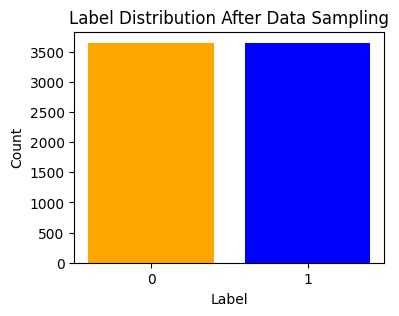

In [124]:
labels = balanced_df_up['label'].value_counts().index
counts = balanced_df_up['label'].value_counts().values

plt.figure(figsize=(4, 3))
plt.bar(labels, counts, color=['blue', 'orange']) # Corrected line
plt.title('Label Distribution After Data Sampling')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(labels)
plt.show()

In [127]:
new_train_set_processed = balanced_df_up
val_set_processed
test_set

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0


# Q2.e Re-trained Model on Clean Dataset

In [134]:
new_train_set_processed = balanced_df_up
new_train_set_processed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7290 non-null   object
 1   label   7290 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 114.0+ KB


In [133]:
val_set_processed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 7033 to 63
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   par_id     1675 non-null   object
 1   community  1675 non-null   object
 2   text       1675 non-null   object
 3   label      1675 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 65.4+ KB


In [119]:
test_set

,par_id,community,text,label
0,4046,hopeless,We also know that they can benefit by receivin...,1
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0


## Deberta

In [120]:
deberta_model_args = ClassificationArgs(
    num_train_epochs = 4,
    learning_rate=2e-5,
    overwrite_output_dir=True,
    evaluate_during_training=True,
    manual_seed=42,
    use_early_stopping=True,
    early_stopping_consider_epochs=True,
    early_stopping_patience=3,
    save_steps=-1,  # Save the model only at the end of training
    train_batch_size=16,
    eval_batch_size=8,
)

deberta_model = ClassificationModel(
    'deberta',
    'microsoft/deberta-base',
    args=deberta_model_args,
    num_labels=2,
    use_cuda=cuda_available
    )


deberta_model.train_model(new_train_set_processed[['text', 'label']], eval_df=val_set_processed[['text', 'label']])


result, model_outputs, wrong_predictions = deberta_model.eval_model(val_set_processed[['text', 'label']])


print(result)

predictions_deberta, raw_outputs = deberta_model.predict(test_set['text'].tolist())
evaluate_model(test_set['label'].tolist(),predictions_deberta )


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/760 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/760 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/760 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/210 [00:00<?, ?it/s]

{'mcc': 0.400680413563431, 'accuracy': 0.888955223880597, 'f1_score': 0.4624277456647398, 'tp': 80, 'tn': 1409, 'fp': 97, 'fn': 89, 'auroc': 0.8115290318017869, 'auprc': 0.4651146478000784, 'eval_loss': 0.749683819298904}


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

F1 Score: 0.3711340206185567
Accuracy: 0.9126074498567335
Precision: 0.5869565217391305
Recall: 0.271356783919598
Confusion Matrix:
[[1857   38]
 [ 145   54]]


## Roberta

In [121]:
roberta_model_args = ClassificationArgs(
    num_train_epochs = 4,
    learning_rate=2e-5,
    overwrite_output_dir=True,
    evaluate_during_training=True,
    manual_seed=42,
    use_early_stopping=True,
    early_stopping_consider_epochs=True,
    early_stopping_patience=3,
    save_steps=-1,  # Save the model only at the end of training
    train_batch_size=16,
    eval_batch_size=8,
)

roberta_model = ClassificationModel(
    'roberta',
    'roberta-base',
    args=roberta_model_args,
    num_labels=2,
    use_cuda=cuda_available
    )


roberta_model.train_model(new_train_set_processed[['text', 'label']], eval_df=val_set_processed[['text', 'label']])


result, model_outputs, wrong_predictions = roberta_model.eval_model(val_set_processed[['text', 'label']])


print(result)

predictions_roberta, raw_outputs = roberta_model.predict(test_set['text'].tolist())
evaluate_model(test_set['label'].tolist(),predictions_roberta )


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/760 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/760 [00:00<?, ?it/s]

KeyboardInterrupt: 

## BOW

tokenize words of length 3 to 10, use unigrams (ngram_range=(1, 1)), limit the features to the 23,000 most frequent words, and exclude English stop words.

Training: The Logistic Regression model is trained with a very high regularization strength (C=1500) and a high iteration limit to ensure convergence.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
#reference: https://www.kaggle.com/code/ziedbaklouti/bow-logistic-regression-sklearn?scriptVersionId=33955168&cellId=5

# Preprocess and Vectorize Text Data
vect1 = CountVectorizer(token_pattern=r'\w{3,10}', ngram_range=(1, 1),
                        max_features=23000, stop_words='english')

# Fit the vectorizer on the training data and transform the training data
X_train_vect = vect1.fit_transform(new_train_set_processed['text'])
# Transform the val data
X_val_vect = vect1.transform(val_set_processed['text'])

#Train a Logistic Regression Model
log_reg1 = LogisticRegression(C=1500, max_iter=10000)

# Fit the model on the vectorized training data
log_reg1.fit(X_train_vect, new_train_set_processed['label'])

#Make Predictions and Evaluate the Model
y_predicted_val = log_reg1.predict(X_val_vect)
print('------Val Set--------------')
evaluate_model(val_set_processed['label'],y_predicted_val)

# Transform the test data
print('------Test Set--------------')
X_test_vect = vect1.transform(test_set['text'])
y_predicted_test = log_reg1.predict(X_test_vect)
evaluate_model(test_set['label'],y_predicted_test)


In [ ]:
misclassified_indices = np.where(y_predicted_val != val_set_processed['label'])[0]

# first misclassified example
if len(misclassified_indices) > 0:
    example_index = misclassified_indices[0]
    misclassified_text = val_set_processed['text'].iloc[example_index]
    true_label = val_set_processed['label'].iloc[example_index]
    predicted_label = y_predicted_val[example_index]

    print("Example of Misclassified Text:")
    print(f"Text: {misclassified_text}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
else:
    print("No misclassified examples found.")


## TD-IDF

uses unigrams (ngram_range=(1, 1)), which may not capture the sentiment expressed through phrases.

Max Features Limitation: Limiting to 1000 max features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess and Vectorize Text Data using TF-IDF
vect1 = TfidfVectorizer(ngram_range=(1, 1),max_features=1000, stop_words='english').fit(train_set.text)

# Fit the vectorizer on the training data and transform the training data
X_train_vect = vect1.fit_transform(new_train_set_processed['text'])
# Transform the validation data
X_val_vect = vect1.transform(val_set_processed['text'])

# Train a Logistic Regression Model
log_reg1 = LogisticRegression(C=1500, max_iter=10000)

# Fit the model on the vectorized training data
log_reg1.fit(X_train_vect, new_train_set_processed['label'])
print('------Val Set--------------')
# Make Predictions and Evaluate the Model on the validation set
y_predicted_val = log_reg1.predict(X_val_vect)
evaluate_model(val_set_processed['label'],y_predicted_val)
print('------Test Set--------------')

X_test_vect = vect1.transform(test_set['text'])
y_predicted_test = log_reg1.predict(X_test_vect)
evaluate_model(test_set['label'],y_predicted_test)

In [ ]:
import numpy as np

# Identifying indices of misclassified examples in the validation set
misclassified_indices_val = np.where(y_predicted_val != val_set_processed['label'])[0]

if len(misclassified_indices_val) > 0:
    example_index_val = misclassified_indices_val[0]  # Just choose the first misclassified example for analysis
    misclassified_text_val = val_set_processed['text'].iloc[example_index_val]
    true_label_val = val_set_processed['label'].iloc[example_index_val]
    predicted_label_val = y_predicted_val[example_index_val]

    print("Example of Misclassified Text in Validation Set:")
    print(f"Text: {misclassified_text_val}")
    print(f"True Label: {true_label_val}, Predicted Label: {predicted_label_val}")
else:
    print("No misclassified examples found in the validation set.")


# Q3

# Prepare submission

In [ ]:
!cat dev.txt | head -n 10

In [ ]:
!zip submission.zip dev.txt test.txt

In [ ]:
!cat test.txt | head -n 10